In [1]:
import cclib
import numpy as np
import matplotlib.pyplot as plt

import overreact as rx
from overreact import constants

%matplotlib inline
# TODO(schneiderfelipe): merge this notebook with the general hydrogen abstraction ones.

I want to reproduce the results of [this paper](https://doi.org/10.1002/qua.25686):

$$\require{mhchem}\ce{CH4 + Cl^{.} <=> RC -> RC^{\ddagger} <=> CH3^{.} + HCl}$$

In [2]:
scheme = rx.parse_reactions("""
    CH4 + Cl. -> RC# -> CH3. + HCl
""")
scheme

Scheme(compounds=('CH4', 'Cl.', 'RC#', 'CH3.', 'HCl'), reactions=('CH4 + Cl. -> CH3. + HCl',), is_half_equilibrium=(False,), A=((-1.0,), (-1.0,), (0.0,), (1.0,), (1.0,)), B=((-1.0,), (-1.0,), (1.0,), (0.0,), (0.0,)))

Now let's read some data from files:

In [3]:
# TODO(schneiderfelipe): correct file paths
logfiles = {
    "CH4": cclib.ccopen("../../data/tanaka1996/UMP2/6-311G(2df,2pd)/methane.out").parse().getattributes(),
    # "RC": cclib.ccopen("../../data/tanaka1996/UMP2/6-311G(2df,2pd)/reactants.out").parse().getattributes(),
    "RC#": cclib.ccopen("../../data/tanaka1996/UMP2/6-311G(2df,2pd)/H3CHCl‡.out").parse().getattributes(),
    # "PC": cclib.ccopen("../../data/tanaka1996/UMP2/6-311G(2df,2pd)/products.out").parse().getattributes(),
    "CH3.": cclib.ccopen("../../data/tanaka1996/UMP2/6-311G(2df,2pd)/CH3·.out").parse().getattributes(),
    "HCl": cclib.ccopen("../../data/tanaka1996/UMP2/6-311G(2df,2pd)/HCl.out").parse().getattributes(),
#     "Cl.": cclib.ccopen("../../data/Dzib_2018/cl.out").parse().getattributes(),
    "Cl.": {
        "enthalpy": -459.62856787 - 0.00283260,
        "entropy": 0.00065446 + 0.01740262,  # S(el) + S(vib) + S(rot) + S(trans)
    },
}
logfiles["Cl."]["freeenergy"] = logfiles["Cl."]["enthalpy"] - logfiles["Cl."]["entropy"]

freeenergy = np.array([logfiles[compound]["freeenergy"] for compound in scheme.compounds])
freeenergy

array([ -40.4036992 , -459.64945755, -500.09767564,  -39.74222623,
       -460.37034858])

In [4]:
Gconc = constants.R * 298.15 * np.log(constants.atm / (constants.R * 298.15))
Gconc / 4184.0

2.1984125935789756

The below is just to remind myself that the enthalpy and entropy come out subtractively contributing to the free energy in ORCA!

In [5]:
logfiles["CH4"]["enthalpy"] - logfiles["CH4"]["entropy"] == logfiles["CH4"]["freeenergy"]

False

Some barriers, which will then be adjusted for molecularity (if needed, it's easier to adjust the absolute Gibbs energies by ):

In [6]:
barriers = rx.get_delta(scheme.B, freeenergy * (constants.hartree * constants.N_A) + Gconc)
barriers / 4184

array([-30.13443784])

In [7]:
molecularity = np.sum(np.where(np.asarray(scheme.A) < 0, -np.asarray(scheme.A), 0), axis=0)
molecularity

array([2.])

In [8]:
k = rx.rates.eyring(barriers)
k

array([7.62005823e+34])

In [9]:
1e-6 * k[0]

7.620058225079301e+28

In [10]:
scheme.reactions

('CH4 + Cl. -> CH3. + HCl',)

array([0.00497512, 0.00497512, 0.        , 0.99502488, 0.99502488])

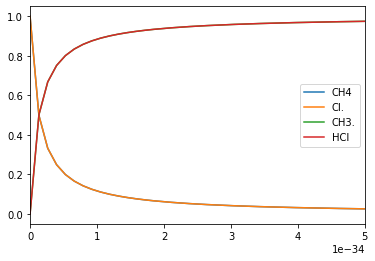

In [11]:
dydt = rx.get_dydt(scheme, k)
y, r = rx.get_y(dydt, y0=[1.0, 1.0, 0.0, 0.0, 0.0])

t = np.linspace(y.t_min, y.t_max, num=200)
for i, compound in enumerate(scheme.compounds):
    if not rx.is_transition_state(compound):
        plt.plot(t, y(t)[i], label=compound)
plt.legend()
plt.xlim(0.0, 0.5e-33)

y(y.t_max)

DeviceArray([-1.88610576e+30, -1.88610576e+30,  0.00000000e+00,
              1.88610576e+30,  1.88610576e+30], dtype=float64)

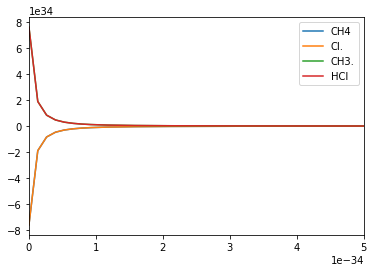

In [12]:
for i, compound in enumerate(scheme.compounds):
    if not rx.is_transition_state(compound):
        plt.plot(t, r(t)[i], label=compound)
plt.legend()
plt.xlim(0.0, 0.5e-33)

r(y.t_max)